In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import sklearn.cluster as cluster
from scipy import stats


In [2]:
def read_data(indicator_code):
    '''
    Reads the enitre world bank data for climate change and returns data of the required indicator
    '''
    df = pd.read_csv('API_19_DS2_en_csv_v2_21025708.csv',skiprows=3)
    new_df = df[df['Indicator Code'] == indicator_code].drop(labels=['Country Code', 'Indicator Name', 'Indicator Code','Unnamed: 66'],axis=1)
    new_df = new_df.set_index('Country Name')
    return new_df, new_df.transpose()

In [3]:
value_added_years, value_added_countries = read_data('NV.AGR.TOTL.ZS')

In [4]:
co2_emissions_years, co2_emissions_countries = read_data('EN.ATM.CO2E.KT')

In [5]:
energy_use_years, energy_use_countries = read_data('EG.USE.PCAP.KG.OE')

In [6]:
def normalize(v):
    '''
    Scales the data to 0 - 1
    '''
    return (v - v.min()) / (v.max() - v.min())

In [7]:
def clustering(data1,data2,col_names=None):
    '''
    Plots 3 clusters of the data given
    '''
    df = pd.DataFrame({0:data1,1:data2}).dropna()

    
    #removing outliers
    df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
    
    data1 = df[0]
    data2 = df[1]
    
    x = data1.values.reshape(-1, 1)
    y = data2.values
    
    kmeans = cluster.KMeans(n_clusters=3)
    kmeans.fit(normalize(x),normalize(y))
    
    cen = kmeans.cluster_centers_
    labels = kmeans.labels_
    
    col = ["blue", "red", "green"]
    for l in range(len(cen)):
        plt.plot(x[labels==l], y[labels==l], "o", markersize=3, color=col[l])
        
    if col_names:
        plt.xlabel(col_names[0])
        plt.ylabel(col_names[1])

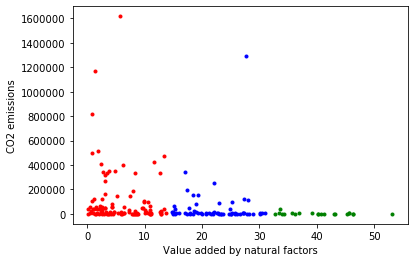

In [8]:
clustering(value_added_countries.mean(),co2_emissions_countries.mean(),
           col_names=['Value added by natural factors', 'CO2 emissions'])

The above cluster shows value added to gdp from natural factors and co2 emissions. As expected countries with less natural resources have higher CO2 emissions. Countries in the blue cluster are at threat from climate change as decrease in their natural factors will significantly affect their gdp.

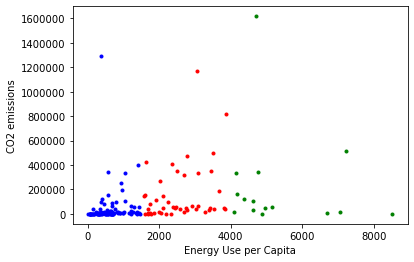

In [9]:
clustering(energy_use_countries.mean(),co2_emissions_countries.mean(),
           col_names=['Energy Use per Capita', 'CO2 emissions'])

The cluster shows carbon emissions with respect to energy use per capita. The clusters indicate that most countries have a low energy use per capita as most countries lie in the blue cluster. The red cluster shows countries that have a mediocre energy use however they have the highest co2 emissions. Generally the data suggests that more the energy use more the co2 emissions

In [10]:
def err_ranges(x, func, param, sigma):
    """
    Calculates the upper and lower limits for the function, parameters and
    sigmas for single value or array x. Functions values are calculated for 
    all combinations of +/- sigma and the minimum and maximum is determined.
    Can be used for all number of parameters and sigmas >=1.
    
    This routine can be used in assignment programs.
    """

    import itertools as iter
    
    # initiate arrays for lower and upper limits
    lower = func(x, *param)
    upper = lower
    
    uplow = []   # list to hold upper and lower limits for parameters
    for p,s in zip(param, sigma):
        pmin = p - s
        pmax = p + s
        uplow.append((pmin, pmax))
        
    pmix = list(iter.product(*uplow))
    
    for p in pmix:
        y = func(x, *p)
        lower = np.minimum(lower, y)
        upper = np.maximum(upper, y)
        
    return lower, upper

In [11]:
def logistic(t, n0, g, t0,b):
    """Calculates the logistic function with scale factor n0 and growth rate g"""
    
    f = n0 / (1 + np.exp(-g*(t - t0))) + b
    
    return f

In [12]:
def predict(x_values,y_values,p0=None,ylabel=None):
    '''
    Predicts the next 10 years of data using the logistic function
    '''
    time = range(x_values[0],x_values[-1]+10)

    params, error = curve_fit(logistic, x_values, y_values,p0=p0,maxfev = 5000)
    
    y_pred = logistic(time,*params)
    
    sigma = np.sqrt(np.diag(error))
    low, up = err_ranges(time, logistic, params, sigma)
    
    plt.plot(time,y_pred)
    plt.plot(x_values,y_values)
    
    plt.fill_between(time, low, up, color="Yellow", alpha=0.5)
    plt.xlabel('Year')
    plt.ylabel(ylabel)
    plt.legend(['predicted', 'original'])
    plt.show()

In [13]:
x_values = value_added_countries['China'].dropna().index.values.astype('int')
y_values = value_added_countries['China'].dropna().values

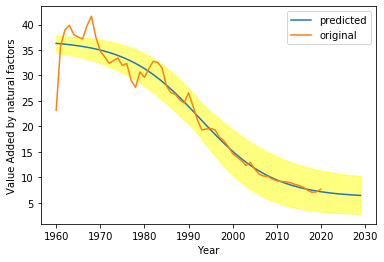

In [14]:
predict(x_values,y_values,(1500,0.4,2000,500),ylabel='Value Added by natural factors')

The plot shows value added by natural resources of China. The data is alarming as it shows that natural resources are depleting. The model predicts that natural resources will only add 5% to the entire gdp by 2030. 

In [15]:
x_values = energy_use_countries['China'].dropna().index.values.astype('int')
y_values = energy_use_countries['China'].dropna().values

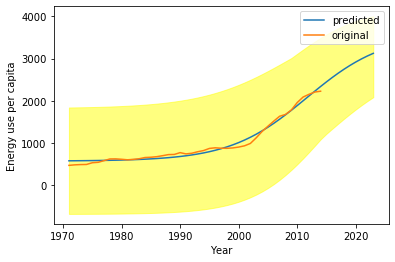

In [16]:
predict(x_values,y_values,(3e12, 0.03, 2000.0,0),ylabel='Energy use per capita')

The plot shows the energy use per capita of china over the past 40 years. The graph is trending upwards which means that china's energy is increasing every year. The predictions indicate a further rise in energy usage as by 2030 each person will be responsible for 3000 kW of energy. 